In [1]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
import importlib


from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair

from ATARI.ModelData.experimental_model import Experimental_Model

from copy import copy

from ATARI.AutoFit import chi2_eliminator_v2
from ATARI.AutoFit import elim_addit_funcs


In [2]:
%matplotlib widget

## Measurement Data

The following measurement data are imported from the work of Jesse Brown at RPI (currently at ORNL).
These measurements are detailed in https://www.tandfonline.com/doi/full/10.1080/00295639.2023.2249786 and consist of 6 experimental configurations.
Of the 4 transmission measurements only 3 are used for evaluation and the 4th (45m FP) is used for validation. 
Both 2 capture measurements are used in evaluation.

The transmission data are reliable in the range 0.15-100 keV.
The capture data are reliable from 0.15-200 keV. 



In [3]:
### Determine channel widths
from ATARI.theory.experimental import e_to_t, t_to_e

def get_chw_and_upperE(E, FP):
    E = np.array(E)
    tof = e_to_t(E, FP, True)
    dt = np.diff(tof*1e6)
    widths1, index1 = np.unique(np.round(dt, 4), return_index=True)
    chw, Emax = np.flipud(widths1), np.flipud(E[index1])
    strc = ''
    stre = ''
    for c,e in zip(chw, Emax):
        strc += f"{c*1e3:.2f}, "
        stre += f"{e:.2f}, "
    return stre, strc

# Emax, chw = get_chw_and_upperE(transdat6.E, 100.14)
# Emax, chw = get_chw_and_upperE(capdat1.E, 45.27)
# print(Emax)
# print(chw)

energy_range_all = [202, 227]

In [4]:
### 1mm capture data
capdat1 = sammy_functions.readlst("./yield_ta1b_unsmooth.dat")
expcap1 = Experimental_Model(title = "cap1mm",
                                reaction ="capture", 
                                energy_range = energy_range_all,
                                n = (0.005631, 0),
                                FP = (45.27, 0.05),
                                burst= (8.0,1.0), 
                                temp= (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [68.20,  122.68, 330.48, 547.57, 199359.52], 
                                    "chw":  [821.40, 410.70, 102.70, 51.30,  25.70],
                                    "dchw": [0.8,    0.8,    0.8,    0.8,    0.8]
                                }
                               )
capdat1 = capdat1.loc[(capdat1.E<max(expcap1.energy_range)) & (capdat1.E>min(expcap1.energy_range)), :]


### 2mm capture data
capdat2 = sammy_functions.readlst("./yield_ta2_unsmooth.dat")
expcap2 = Experimental_Model(   title = "cap2mm",
                                reaction = "capture", 
                                energy_range = energy_range_all,
                                n = (0.011179, 0.0),
                                FP = (45.27, 0.05),
                                burst = (8.0,1.0),
                                temp = (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [68.20,  122.68, 330.48, 547.57, 199359.52], 
                                    "chw":  [821.40, 410.70, 102.70, 51.30,  25.70],
                                    "dchw": [0.8,    0.8,    0.8,    0.8,    0.8]
                                }
                               )
capdat2 = capdat2.loc[(capdat2.E<max(expcap2.energy_range)) & (capdat2.E>min(expcap2.energy_range)), :]


### 1mm Transmission data
transdat1 = sammy_functions.readlst("./trans-Ta-1mm.twenty")
transdat1_covfile = './trans-Ta-1mm.idc'
chw, Emax = get_chw_and_upperE(transdat1.E, 100.14)
exptrans1 = Experimental_Model(title = "trans1mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,

                                n = (0.00566,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat1 = transdat1.loc[(transdat1.E<max(exptrans1.energy_range)) & (transdat1.E>min(exptrans1.energy_range)), :]

### 3mm transmission data
transdat3 = sammy_functions.readlst("./trans-Ta-3mm.twenty")
transdat3_covfile = "./trans-Ta-3mm.idc"
exptrans3 = Experimental_Model(title = "trans3mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,

                                n = (0.017131,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat3 = transdat3.loc[(transdat3.E<max(exptrans3.energy_range)) & (transdat3.E>min(exptrans3.energy_range)), :]


### 6mm transmission data
transdat6 = sammy_functions.readlst("./trans-Ta-6mm.twenty")
transdat6_covfile = "./trans-Ta-6mm.idc"
exptrans6 = Experimental_Model(title = "trans6mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,

                                n = (0.03356,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat6 = transdat6.loc[(transdat6.E<max(exptrans6.energy_range)) & (transdat6.E>min(exptrans6.energy_range)), :]


### Not using 12mm measurement for evaluation - this is a validation measurement

# transdat12 = sammy_functions.readlst("/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-12mm.dat")
# # transdat12_covfile = Need to generate from sys and stat covariances
# exptrans12 = Experimental_Model(title = "trans12",
#                                 reaction = "transmission",
#                                 energy_range = erange_all,

#                                 sammy_inputs = {
#                                     'alphanumeric'       :   ["BROADENING IS WANTED"],
#                                     'ResFunc'            :   "ORRES"
#                                         },

#                                 n = (0.067166, 0.0),  
#                                 FP = (35.185,0.0), 
#                                 burst = (8,0.0), 
#                                 temp = (294.2610, 0.0),

#                                 channel_widths={
#                                         "maxE": [270], 
#                                         "chw": [102.7],
#                                         "dchw": [0.8]
#                                         },

#                                 additional_resfunc_lines=["WATER 0004 5.6822000 -0.54425 0.07733000", "WATER      0.5000000  0.05000 0.00700000", "LITHI 000  -1.000000  -1.0000 6.00000000", "LITHI      0.1000000  0.10000 0.60000000", "LITHI      166.87839 -28.7093 1.260690", "LITHI      0.2574580 -0.06871 0.004915"]
#                                )

# transdat12 = transdat12[(transdat12.E<max(exptrans12.energy_range)) & (transdat12.E>min(exptrans12.energy_range))]


In [5]:
### plotting function
def plot(datasets, experiments, fits=[], priors=[], true=[]):
    colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

    for i, exp in enumerate(experiments):
        if exp.reaction == "transmission":
            model_key = "theo_trans"
            iax = 0
        elif exp.reaction == "capture":
            model_key = "theo_xs"
            iax = 1
        else:
            raise ValueError()

        axes[iax].errorbar(datasets[i].E, datasets[i].exp, yerr=datasets[i].exp_unc, zorder=0,
                                                fmt='.', color=colors[i], linewidth=0.5, markersize=1.5, capsize=1, label=exp.title)
        
        if len(fits) != 0:
            axes[iax].plot(fits[i].E, fits[i][model_key], color=colors[i], lw=1.5, label=f'fit {exp.title}')

        if len(priors) != 0:
            axes[iax].plot(priors[i].E, priors[i][model_key], '--', color=colors[i], lw=1.5) #, label=f'prior {exp.title}')
        if len(true) != 0:
            axes[iax].plot(true[i].E, true[i][model_key], '-', color=colors[i], alpha=0.5, lw=1.5) #, label=f'prior {exp.title}')

        
    axes[0].set_ylabel("T")
    axes[1].set_ylabel(r"$Y_{\gamma}$")

    ### make it pretty
    for ax in axes:

        ax.set_xscale('log')
        ax.set_ylim([-0.1,1.1])
        ax.legend()

    fig.supxlabel('Energy (eV)')
    fig.tight_layout()

    return fig


# little bit modified

def plot_datafits(datasets, experiments, 
    fits=[], fits_chi2=[], f_model_name='fit',
    priors=[], priors_chi2=[], pr_model_name='prior',
    true=[], true_chi2=[], t_model_name ='true',
    true_pars = pd.DataFrame(), 
    prior_pars = pd.DataFrame(),
    fit_pars = pd.DataFrame(),
    title: str = '',
    show_spingroups: bool = True,
    fig_size : tuple = (12,9)
    ):

    colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    fig, axes = subplots(2,1, figsize=fig_size, sharex=True)

    for i, exp in enumerate(experiments):
        if exp.reaction == "transmission":
            model_key = "theo_trans"
            iax = 0
        elif exp.reaction == "capture":
            model_key = "theo_xs"
            iax = 1
        else:
            raise ValueError()

        axes[iax].errorbar(datasets[i].E, datasets[i].exp, yerr=datasets[i].exp_unc, zorder=0,
                                                fmt='.', color=f'{colors[i]}', alpha=0.5, linewidth=1.0, markersize=4, capsize=1, label=exp.title)
        
        if len(fits) != 0:
            if (len(fits_chi2) != 0):
                fit_label = f'{f_model_name} {exp.title} ({fits_chi2[i]})'
            else:
                fit_label = f'{f_model_name} {exp.title}'
            axes[iax].plot(fits[i].E, fits[i][model_key], color='red', zorder=1, lw=1.5, label=fit_label) # colors[i]
        
        if len(priors) != 0:
            if (len(priors_chi2) != 0):
                prior_label = f'{pr_model_name} {exp.title} ({priors_chi2[i]})'
            else:
                prior_label = f'{pr_model_name} {exp.title}'

            axes[iax].plot(priors[i].E, priors[i][model_key], '--', color='orange', zorder=0, lw=1.5, label=prior_label)
        
        if len(true) != 0:
            if (len(true_chi2) != 0):
                true_label = f'{t_model_name} {exp.title} ({true_chi2[i]})'
            else:
                true_label = f'{t_model_name} {exp.title}'
                
            axes[iax].plot(true[i].E, true[i][model_key], '-', color='green', zorder=1, alpha=0.5, lw=1.5, label=true_label)


    # Set the y-axis limits with additional space for text and capture ymax before changing
    
    y_top_padding = 0.1 
    x_offset = 0.05

    ymax_values = [ax.get_ylim()[1] for ax in axes]  # Store original ymax values for each axis
    for ax in axes:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin, ymax + y_top_padding)

    font_size = 8
    y_text_shift = 0.01  # Adjust as needed, related to font size
    y_text_positions = [ymax_values[0], ymax_values[1]]

    # show vertical lines for energies
    
    # fits
    for index, res in fit_pars.iterrows():
        res_E = res.E
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=res_E, color='red', linestyle='--', linewidth=0.5, alpha=0.3)
        axes[1].axvline(x=res_E, color='red', linestyle='--', linewidth=0.5, alpha=0.3)

        if (show_spingroups):
            # add txt with
            sp_gr_txt = np.round(int(res.J_ID),0)
            
            y_text_position = ymax  # Position the text at the top of the original y-axis limit
            x_text_position = res_E + x_offset
            
            # Show the text to the right of the line
            for i, ax in enumerate(axes):
                y_text_position = ymax_values[i]  # Use original ymax for text position
                #ax.text(x_text_position, y_text_position, str(sp_gr_txt), color='red', verticalalignment='bottom', fontsize=8)

                ax.text(res_E, y_text_positions[i], str(sp_gr_txt), color='red', verticalalignment='bottom', fontsize=font_size)
                y_text_positions[i] -= y_text_shift


    # the same for theoretical positions
    for index, true_res in true_pars.iterrows():

        true_res_energy = true_res.E
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=true_res_energy, color='g', linestyle='--', linewidth=0.5, alpha=0.7)
        axes[1].axvline(x=true_res_energy, color='g', linestyle='--', linewidth=0.5, alpha=0.7)

        if (show_spingroups):
            # add txt with
            sp_gr_txt = np.round(true_res.J_ID,0)
            y_text_position = ymax  # Position the text at the top of the original y-axis limit
            x_text_position = true_res_energy
            
            # Show the text to the right of the line
            for i, ax in enumerate(axes):
                y_text_position = ymax_values[i]  # Use original ymax for text position
                ax.text(x_text_position , y_text_position, str(sp_gr_txt), color='g', verticalalignment='bottom', fontsize=8)

    
    for index, res in prior_pars.iterrows():
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=res.E, color='orange', linestyle='--', linewidth=0.5, alpha=0.5)
        axes[1].axvline(x=res.E, color='orange', linestyle='--', linewidth=0.5, alpha=0.5)

        
    axes[0].set_ylabel("T")
    axes[1].set_ylabel(r"$Y_{\gamma}$")

    # set title
    fig.suptitle(title, fontsize=14)
    
    # additional info if present
    add_title = ''
    if (true_pars.shape[0]>0):
        add_title+=''+r'$N_{'+f'{t_model_name}'+'}$ = '+str(true_pars.shape[0])
        
    if (len(true_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(true_chi2),3))

    if (prior_pars.shape[0]>0):
        add_title+=', '+r'$N_{'+f'{pr_model_name}'+'}$ = '+str(prior_pars.shape[0])
    if (len(priors_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(priors_chi2),3))

    if (fit_pars.shape[0]>0):
        add_title+=', '+r'$N_{'+f'{f_model_name}'+'}$ = '+str(fit_pars.shape[0])
    if (len(fits_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(fits_chi2),3))
    
    # end additional info if present
    axes[0].set_title(add_title, fontsize=10)
    

    # ### make it pretty
    for ax in axes:
        # ax.set_xlim([200,250])
        # ax.set_ylim([-0.1,1.1])
        ax.legend(fontsize='small', loc='lower right')

    fig.supxlabel('Energy (eV)')
    fig.tight_layout()

    return fig

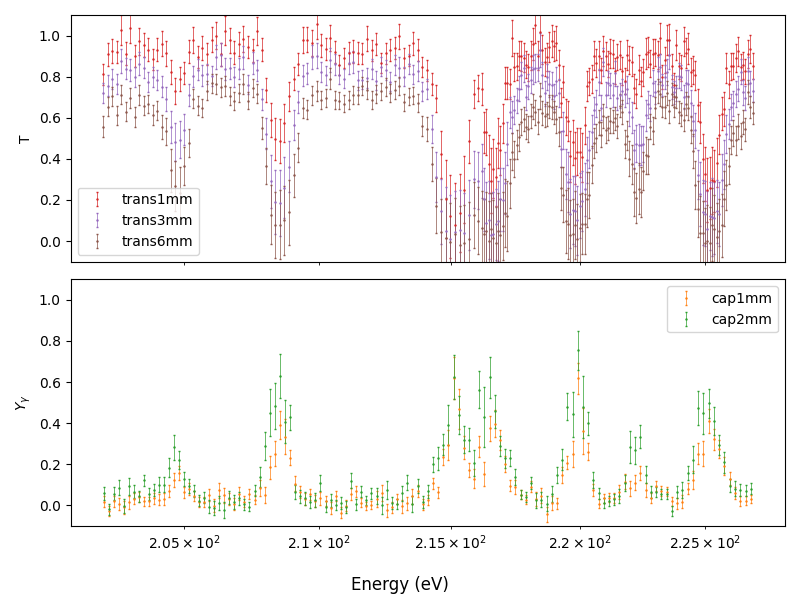

In [6]:
### setup in zipped lists 
datasets = [capdat1, capdat2, transdat1, transdat3, transdat6]
experiments= [expcap1, expcap2, exptrans1, exptrans3, exptrans6]
covariance_data = [{}, {}, transdat1_covfile, transdat3_covfile, transdat6_covfile]
templates = []
for data, exp in zip(datasets, experiments):
    filepath = f'template_{exp.title}_edited'
    exp.template = os.path.realpath(filepath)


fig = plot(datasets, experiments)
fig.tight_layout()

In [7]:
## Could also plot covariance here

In [8]:
sammypath = '/home/fire/SAMMY/sammy/build/install/bin/sammy'

## Fit from ENDF or JEFF

In [9]:
sammyRTO = sammy_classes.SammyRunTimeOptions(#'/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                            sammyexe=sammypath,
                            options= {"Print"   :   True,
                              "bayes"   :   False,
                              "keep_runDIR"     : True
                              })

matnum = 7328

# endf_file = "/Users/noahwalton/research_local/data/neutrons_ENDF-B-VII.1/n-073_Ta_181.endf"
# endf_parameters = sammy_functions.get_endf_parameters(endf_file, matnum, sammyRTO)

# endf_parameters = endf_parameters[(endf_parameters.E<260) & (endf_parameters.E>190)]
# endf_parameters["varyGn1"] = np.ones(len(endf_parameters))
# endf_parameters["varyGg"] = np.ones(len(endf_parameters))*0
# endf_parameters["varyE"] = np.ones(len(endf_parameters))

jeff_file = "/Users/noahwalton/research_local/data/JEFF33_endf6/73-Ta-181g.jeff33"
jeff_file = "./73-Ta-181g.jeff33"
jeff_parameters = sammy_functions.get_endf_parameters(jeff_file, matnum, sammyRTO)

jeff_parameters = jeff_parameters[(jeff_parameters.E<max(energy_range_all)+10) & (jeff_parameters.E>min(energy_range_all)-10)]
jeff_parameters["varyGn1"] = np.ones(len(jeff_parameters))
jeff_parameters["varyGg"] = np.ones(len(jeff_parameters))*0
jeff_parameters["varyE"] = np.ones(len(jeff_parameters))

jeff_parameters

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
46,194.80,55.0000,99.5555,1.0,0.0,1.0,2.0
47,200.00,63.0000,31.4285,1.0,0.0,1.0,1.0
48,204.67,64.9999,2.7540,1.0,0.0,1.0,1.0
49,208.48,64.9999,9.4220,1.0,0.0,1.0,2.0
50,215.09,64.9999,48.2700,1.0,0.0,1.0,2.0
51,216.60,64.9999,19.3900,1.0,0.0,1.0,1.0
52,219.81,64.9999,12.8800,1.0,0.0,1.0,2.0
53,222.29,64.9999,2.4360,1.0,0.0,1.0,2.0
54,225.15,64.9999,20.5700,1.0,0.0,1.0,2.0
55,230.62,64.9999,22.4200,1.0,0.0,1.0,2.0


In [10]:

Ta_pair = Particle_Pair(isotope="Ta181",
                        formalism="XCT",
                        ac=8.1271,     # scattering radius
                        M=180.948030,  # amu of target nucleus
                        m=1,           # amu of incident neutron
                        I=3.5,         # intrinsic spin, positive parity
                        i=0.5,         # intrinsic spin, positive parity
                        l_max=2)       # highest order l-wave to consider

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D_avg=8.79,
                       Gn_avg=46.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D_avg=4.99,
                       Gn_avg=35.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)


rto = sammy_classes.SammyRunTimeOptions(
    sammyexe=sammypath,
                             options = {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : True
                              })


sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = jeff_parameters,  

    datasets= datasets,
    experiments = experiments,
    experimental_covariance=covariance_data,  #[{}, {}, {}, {}, {}], # 
    
    max_steps = 10,
    iterations = 2,
    step_threshold = 0.1,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 2,
    LevMarVd= 5,
    initial_parameter_uncertainty = 0.1
    )



In [11]:
# size of the dataset - to compare

# dataset size
sum_points = 0 
for index,el in enumerate(datasets):
    sum_points += el.shape[0]

print(f'Datasets: {len(datasets)}')
print(f'Num of points: {sum_points}')

Datasets: 5
Num of points: 851


In [12]:
sammyOUT = sammy_functions.run_sammy_YW(sammyINPyw, rto)

Stepping until convergence
chi2 values
step fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum']
0    0.1  : [2.2473, 1.998, 1.0691, 1.4219, 1.745, 8.4812]
1    0.2  : [1.8819, 1.9113, 0.8945, 1.0614, 1.2228, 6.972]
2    0.4  : [1.8846, 1.9131, 0.8903, 1.05, 1.2132, 6.9512]
Chi2 improvement below threshold


In [13]:
# prior_lsts = lsts
def printout_chi2_post(sammyOUT: sammy_classes.SammyOutputData, addstr :str = 'Solution chi2 values'):
    print(f'{addstr}')
    print('Chi2_n:')
    print('\t Prior:')
    print('\t', sammyOUT.chi2n, np.sum(sammyOUT.chi2n))
    print('\t Posterior:')
    print('\t', sammyOUT.chi2n_post, np.sum(sammyOUT.chi2n_post))

    print('Chi2:')
    print('\t Prior:')
    print('\t', sammyOUT.chi2, np.sum(sammyOUT.chi2))
    print('\t Posterior:')
    print('\t', sammyOUT.chi2_post, np.sum(sammyOUT.chi2_post))

printout_chi2_post(sammyOUT, 'JEFF')

JEFF
Chi2_n:
	 Prior:
	 [2.24725, 1.99795, 1.06907, 1.42193, 1.74499] 8.48119
	 Posterior:
	 [1.88463, 1.91308, 0.890261, 1.05, 1.21319] 6.951161
Chi2:
	 Prior:
	 [285.401, 253.739, 212.744, 282.965, 347.254] 1382.103
	 Posterior:
	 [239.349, 242.961, 177.162, 208.949, 241.424] 1109.845


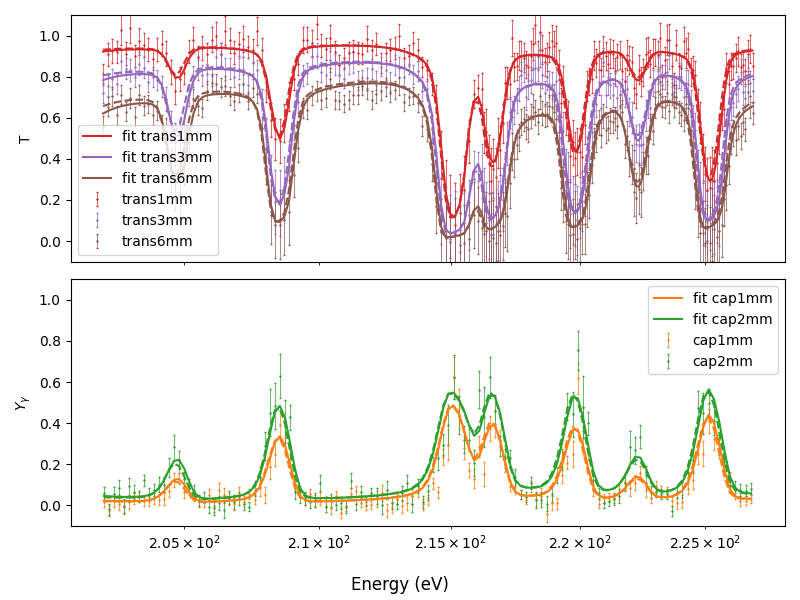

In [14]:
fig = plot(datasets, experiments, fits=sammyOUT.pw_post, priors=sammyOUT.pw)
fig.tight_layout()

In [15]:
sammyOUT.par_post

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
0,194.817542,55.0000,110.237889,1.0,0.0,1.0,2.0
1,200.285962,63.0000,35.673834,1.0,0.0,1.0,1.0
2,204.737853,64.9999,3.106313,1.0,0.0,1.0,1.0
3,208.525385,64.9999,9.738797,1.0,0.0,1.0,2.0
4,215.117671,64.9999,45.916152,1.0,0.0,1.0,2.0
5,216.639146,64.9999,18.009142,1.0,0.0,1.0,1.0
6,219.867430,64.9999,12.534885,1.0,0.0,1.0,2.0
7,222.305679,64.9999,2.714556,1.0,0.0,1.0,2.0
8,225.211622,64.9999,21.934865,1.0,0.0,1.0,2.0
9,230.557622,64.9999,19.611673,1.0,0.0,1.0,2.0


In [16]:
# utilizing the autofit from initial FB

# folder where to save all
savefolder = './data/'
fig_size = (10,6)

Gn_thr = 0.0


from ATARI.AutoFit.initial_FB_solve import InitialFB, InitialFBOPT

sammy_rto_fit = sammy_classes.SammyRunTimeOptions(
    sammyexe=sammypath,
                             options = {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : True
                              })


options = InitialFBOPT(Gn_threshold=Gn_thr, #1e-1,
                       iterations=2)

autofit_initial = InitialFB(options)

In [17]:
outs = autofit_initial.fit(Ta_pair,
                               energy_range_all,
                               datasets,
                               experiments,
                               covariance_data,
                               sammy_rto_fit)

	FIT 1
Initial solve from 62 resonance features

Stepping until convergence
chi2 values
step fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum']
0    0.5  : [8.4998, 9.9908, 0.2667, 0.5572, 0.7823, 20.0968]
1    0.75 : [7.6055, 8.5311, 0.2365, 0.4151, 0.535, 17.3232]
2    1.125: [5.2965, 5.4576, 0.2283, 0.536, 0.9851, 12.5036]
3    1.688: [4.2796, 4.4811, 0.2574, 0.7573, 1.424, 11.1993]
4    2.531: [4.1382, 4.373, 0.2617, 0.8148, 1.526, 11.1137]
Chi2 improvement below threshold

Complete after no neutron width features below threshold

	FIT 2
Initial solve from 62 resonance features

Stepping until convergence
chi2 values
step fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum']
0    0.5  : [4.1382, 4.3731, 0.2617, 0.8148, 1.526, 11.1137]
1    0.75 : [2.415, 2.5306, 0.3522, 0.4813, 0.7508, 6.5299]
2    1.125: [2.1298, 2.259, 0.3939, 0.4695, 0.6779, 5.9302]
Repeat step 3, 	fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum']
		0.225

In [18]:
print(f'Num elements in outs (stages): {len(outs)}')
printout_chi2_post(outs[-1], 'autofit result')
#print(outs[-1].par_post)

printout_chi2_post(outs[0], 'autofit prior')

Num elements in outs (stages): 1
autofit result
Chi2_n:
	 Prior:
	 [4.13817, 4.37306, 0.261659, 0.814819, 1.526] 11.113707999999999
	 Posterior:
	 [2.07909, 2.21605, 0.397178, 0.497333, 0.67835] 5.8680010000000005
Chi2:
	 Prior:
	 [525.548, 555.378, 52.0702, 162.149, 303.675] 1598.8201999999999
	 Posterior:
	 [264.044, 281.438, 79.0383, 98.9693, 134.992] 858.4816
autofit prior
Chi2_n:
	 Prior:
	 [4.13817, 4.37306, 0.261659, 0.814819, 1.526] 11.113707999999999
	 Posterior:
	 [2.07909, 2.21605, 0.397178, 0.497333, 0.67835] 5.8680010000000005
Chi2:
	 Prior:
	 [525.548, 555.378, 52.0702, 162.149, 303.675] 1598.8201999999999
	 Posterior:
	 [264.044, 281.438, 79.0383, 98.9693, 134.992] 858.4816


In [22]:
   
save_obj  = elim_addit_funcs.save_obj_as_pkl(folder_name=savefolder, file_name='Autofit_init_res.pkl', obj = outs)


In [23]:
# reading the prefitted data
outs = elim_addit_funcs.load_obj_from_pkl(folder_name='./data/', pkl_fname='Autofit_init_res.pkl')
final_fb_output = outs[-1]

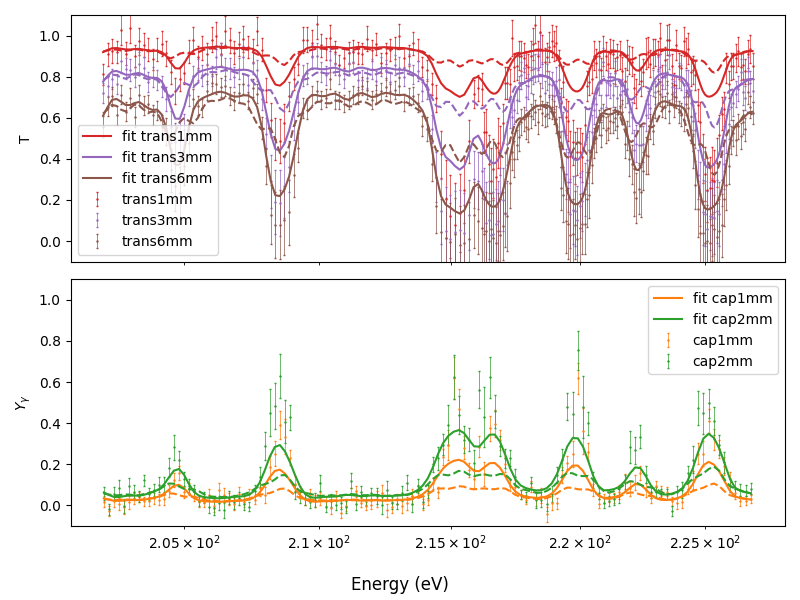

In [24]:
fig = plot(datasets, experiments, fits=final_fb_output.pw_post, priors=final_fb_output.pw)
fig.tight_layout()

In [25]:
print(final_fb_output.chi2)
print(sum(final_fb_output.chi2))
print(final_fb_output.chi2_post)
print(sum(final_fb_output.chi2_post))
print(f'N_res: {final_fb_output.par_post.shape[0]}')

[525.548, 555.378, 52.0702, 162.149, 303.675]
1598.8201999999999
[264.044, 281.438, 79.0383, 98.9693, 134.992]
858.4816
N_res: 62


# Resonance elimination 


In [26]:
import importlib

importlib.reload(chi2_eliminator_v2)
importlib.reload(elim_addit_funcs)

start_ladder = final_fb_output.par_post
assert isinstance(start_ladder, pd.DataFrame)

# side resonances if needed, otherways - keep empty
side_resonances_df = pd.DataFrame()

side_resonances_df = elim_addit_funcs.find_side_res_df(
        initial_sol_df = jeff_parameters,
        energy_region = energy_range_all,
        N_res = 2
)

side_resonances_df = elim_addit_funcs.set_varying_fixed_params(ladder_df=side_resonances_df,
                                                               vary_list=[0,1,1])
print(side_resonances_df)

# compiling to one ladder

start_ladder = pd.concat([side_resonances_df, start_ladder], ignore_index=True)


         E       Gg      Gn1  varyE  varyGg  varyGn1  J_ID
47  200.00  63.0000  31.4285      0       1        1   1.0
55  230.62  64.9999  22.4200      0       1        1   2.0


In [28]:
# if we do not want to wait hours...

N_red = start_ladder.shape[0] # not limiting

# just to reduce processing time
start_ladder = elim_addit_funcs.reduce_ladder(ladder_df=start_ladder,
                             Gn1_threshold=Gn_thr,
                             vary_list=[1,0,1],
                             N=N_red,
                             keep_fixed=True,
                             fixed_side_resonances=side_resonances_df)

print('Start ladder:')
print(start_ladder)


Found side resonances (fixed):
        E       Gg      Gn1  varyE  varyGg  varyGn1  J_ID
0  200.00  63.0000  31.4285    0.0     1.0      1.0   1.0
1  230.62  64.9999  22.4200    0.0     1.0      1.0   2.0
Keeping them: True
Start ladder:
             E         Gg        Gn1  varyE  varyGg  varyGn1  J_ID
0   200.000000  63.000000  31.428500    0.0     1.0      1.0   1.0
1   201.882470  62.508012   0.362357    1.0     0.0      1.0   1.0
2   201.897166  63.066863   0.248181    1.0     0.0      1.0   2.0
3   202.759563  68.840767   0.180123    1.0     0.0      1.0   1.0
4   203.031047  67.564791   0.156348    1.0     0.0      1.0   2.0
..         ...        ...        ...    ...     ...      ...   ...
59  226.375907  65.171695   0.206648    1.0     0.0      1.0   2.0
60  226.396510  63.810721   0.266219    1.0     0.0      1.0   1.0
61  227.158478  64.722556   0.179188    1.0     0.0      1.0   2.0
62  227.168651  64.635342   0.233863    1.0     0.0      1.0   1.0
63  230.620000  64.999900

In [30]:


# defining rto & inputs
elim_sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = start_ladder,

    datasets = datasets,
    experimental_covariance=covariance_data,
    experiments = experiments,

    max_steps = 0,
    iterations = 2,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 1.5,

    minF = 1e-5,
    maxF = 10,
    initial_parameter_uncertainty = 0.05
    )

# defining the elim_opts
elim_opts = chi2_eliminator_v2.elim_OPTs(chi2_allowed = 28,
                                         stop_at_chi2_thr = False,
                                      fixed_resonances_df = side_resonances_df,
                                      deep_fit_max_iter = 20,
                                      deep_fit_step_thr = 0.01,
                                      start_fudge_for_deep_stage = 0.05,
                                      )

In [31]:
elimi = chi2_eliminator_v2.eliminator_by_chi2(rto=sammy_rto_fit,
                                            sammyINPyw = elim_sammyINPyw , 
                                            options = elim_opts
                            )

In [32]:
hist = elimi.eliminate(ladder_df= start_ladder)

****************************************
Elimination cycle printout enabled
****************************************

Chi2 thresold applied for model selection: 28


Input ladder:
             E         Gg        Gn1  varyE  varyGg  varyGn1  J_ID
0   200.000000  63.000000  31.428500    0.0     1.0      1.0   1.0
1   201.882470  62.508012   0.362357    1.0     0.0      1.0   1.0
2   201.897166  63.066863   0.248181    1.0     0.0      1.0   2.0
3   202.759563  68.840767   0.180123    1.0     0.0      1.0   1.0
4   203.031047  67.564791   0.156348    1.0     0.0      1.0   2.0
..         ...        ...        ...    ...     ...      ...   ...
59  226.375907  65.171695   0.206648    1.0     0.0      1.0   2.0
60  226.396510  63.810721   0.266219    1.0     0.0      1.0   1.0
61  227.158478  64.722556   0.179188    1.0     0.0      1.0   2.0
62  227.168651  64.635342   0.233863    1.0     0.0      1.0   1.0
63  230.620000  64.999900  22.420000    0.0     1.0      1.0   2.0

[64 rows x 7 co

In [ ]:
# true - using JEFF? just for comparison

true_chars = elimi.evaluate_prior(jeff_parameters) 
print(true_chars.chi2)

In [ ]:
# just to show how much we aliminated with the given threshold value.
print(f'Eliminated from {hist.ladder_IN.shape[0]} res -> {hist.ladder_OUT.shape[0]}')
print(f'Elim took {np.round(hist.elim_tot_time,2)} sec')

In [ ]:
# save history?

# can we save the history not to refit all the time?

fitted_elim_case_data = {
        'datasets' : datasets,
        'covariance_data' : covariance_data,
    'experiments': experiments,
    'true_chars': true_chars, # note, jeff are used as true here
    'Ta_pair': Ta_pair,
}

saved_hist = elim_addit_funcs.save_obj_as_pkl(folder_name=savefolder, file_name=f'hist_N_red_{N_red}.pkl', obj=hist)
saved_data = elim_addit_funcs.save_obj_as_pkl(folder_name=savefolder, file_name='dataset.pkl', obj=fitted_elim_case_data)


In [ ]:
# plot the final selected fit?
# images production from history

prior_level = max(hist.elimination_history.keys())
prior_numres = hist.elimination_history[prior_level]['input_ladder'].shape[0]
print(f'Initial ladder, num of res.: {prior_numres}')

min_level_passed_test = prior_level # level - key in the hist..
min_N_res_passed_test = prior_level - 1

levels = []
N_ress = []
chi2_s = []

for level in hist.elimination_history.keys():
        
    numres = hist.elimination_history[level]['selected_ladder_chars'].par_post.shape[0]
    pass_test = hist.elimination_history[level]['final_model_passed_test']

    #print(f'level {level}, # of resonances: {numres},  passed the test: {pass_test}')

    if (pass_test and level<min_level_passed_test):
        min_level_passed_test = level

        min_N_res_passed_test = numres
    
    levels.append(level)
    chi2_s.append(np.sum(hist.elimination_history[level]['selected_ladder_chars'].chi2_post))
    N_ress.append(numres)

# plotting    

# differences in chi2 values between 2 models
chi2_diffs = np.diff(chi2_s, prepend=chi2_s[0]) 

fig, (ax1, ax2) = subplots(2, 1, figsize = fig_size, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# First subplot for the original chi2 values
ax1.plot(N_ress, chi2_s, marker='o')
ax1.axvline(x=min_N_res_passed_test, color='r', linestyle='--')

ax1.set_ylabel('$\chi^2$')
ax1.grid(True)

# changes in chi2

ax2.plot(N_ress, chi2_diffs, marker='o', color='green')
ax2.axvline(x=min_N_res_passed_test, color='r', linestyle='--')
ax2.set_xlabel(r'$N_{res}$')
ax2.set_ylabel('Change in $\chi^2$')
ax2.invert_xaxis()
ax2.grid(True)

tight_layout()
fig.savefig(savefolder+'hist_png', dpi=75)
show()

In [ ]:
# plotting data from history
def show_plot_from_hist(
        datasets,
        experiments,
        true_chars,
        true_pars,

        level_to_compare: int,
        min_level_passed_test: int,
        elim_hist: dict,
        ):
    
    fits = elim_hist[level_to_compare]['selected_ladder_chars'].pw_post
    fits_chi2 = elim_hist[level_to_compare]['selected_ladder_chars'].chi2_post

    prior_fit = elim_hist[prior_level]['selected_ladder_chars'].pw
    priors_chi2 = elim_hist[prior_level]['selected_ladder_chars'].chi2

    # outfit
    fig = plot_datafits(datasets, experiments, 
        fits=fits, fits_chi2=fits_chi2, f_model_name=f'autofit + elim {N_red}',
        priors = prior_fit, priors_chi2=priors_chi2, pr_model_name='autofit res, reduced to {N_red}',
        true=true_chars.pw, t_model_name='JEFF (w/o autofit)',
        true_chi2 = true_chars.chi2,
        true_pars = true_pars,
        fit_pars = elim_hist[level_to_compare]['selected_ladder_chars'].par_post,
        prior_pars = elim_hist[prior_level]['input_ladder'],
        title = f'Fit, Prior & True comparison, model # {level_to_compare}, best selected: {min_level_passed_test}',
        show_spingroups=True
        )
    fig.tight_layout()
    return fig

In [ ]:
N_res_to_view = min_N_res_passed_test
level_to_compare = N_res_to_view+1

fig = show_plot_from_hist(datasets = datasets,
                          experiments=experiments,
                          true_chars = true_chars,
                          true_pars = true_chars.par,
                          level_to_compare=level_to_compare,
                          min_level_passed_test= min_level_passed_test,
                          elim_hist = hist.elimination_history
                          )